In [1]:
import numpy as np
import pandas as pd

from scipy import stats
from datetime import datetime, timedelta
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.cm import viridis
from matplotlib.colors import to_hex

import gmaps
import gmaps.geojson_geometries
import json
import copy

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from itertools import product

In [2]:
%%time
raw_data = pd.read_csv('yellow_tripdata_2016-05.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

Wall time: 1min 19s


In [3]:
raw_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [4]:
raw_data.shape

(11836853, 19)

# 1. Data aggregation

In [5]:
%%time
data = raw_data[(raw_data.tpep_pickup_datetime != raw_data.tpep_dropoff_datetime)&(raw_data.passenger_count != 0)
                &(raw_data.trip_distance != 0)]

Wall time: 2.19 s


In [6]:
data.shape

(11763422, 19)

In [7]:
def is_inside_NY(p1, p2):
    a1 = -74.25559
    a2 = -73.70001
    b1 = 40.49612
    b2 = 40.91553
    if ((p1 < a2)&(p1 > a1)&(p2 < b2)&(p2 > b1)):
        return True
    else:
        return False

In [8]:
%%time
data = data[list(map(is_inside_NY, data.pickup_longitude, data.pickup_latitude))]

Wall time: 8min 40s


In [9]:
data.shape

(11626521, 19)

In [11]:
start_time = datetime.strptime('2016-05-01 00', "%Y-%m-%d %H")
end_time = datetime.strptime('2016-05-31 23', "%Y-%m-%d %H")

cur_time = start_time
x = np.linspace(-74.25559, -73.70001, 51)
y = np.linspace(40.49612, 40.91553, 51)
data_agregated = pd.DataFrame(columns=['time', 'region', 'num_of_rides'])

while(cur_time <= end_time):
    cur_time_plus_one = cur_time + timedelta(hours = 1)
    data_cur_time = data[(data.tpep_pickup_datetime >= cur_time)&(data.tpep_pickup_datetime < cur_time_plus_one)]
    
    if (len(data_cur_time) > 0):
        data_temp = stats.binned_statistic_2d(data_cur_time.pickup_longitude, data_cur_time.pickup_latitude, 
                                              None, 'count', bins=[x, y])
        data_temp1 = data_temp.statistic.reshape((2500,))
    else:
        data_temp1 = [0]*2500
    
    data_agregated_temp = pd.DataFrame({'time': cur_time, 'region': range(1, 2501), 'num_of_rides': data_temp1})
    
    data_agregated = data_agregated.append(data_agregated_temp, ignore_index=True)
    cur_time += timedelta(hours = 1)
    
data_agregated = data_agregated[['time', 'region', 'num_of_rides']]

In [12]:
data_agregated.shape

(1860000, 3)

In [13]:
data_agregated.head(10)

,time,region,num_of_rides
0,2016-05-01,1,0.0
1,2016-05-01,2,0.0
2,2016-05-01,3,0.0
3,2016-05-01,4,0.0
4,2016-05-01,5,0.0
5,2016-05-01,6,0.0
6,2016-05-01,7,0.0
7,2016-05-01,8,0.0
8,2016-05-01,9,0.0
9,2016-05-01,10,0.0


In [14]:
empire_state_building = (-73.98583, 40.74778)
data_temp = stats.binned_statistic_2d([empire_state_building[0]], [empire_state_building[1]], 
                                              None, 'count', bins=[x, y])
data_temp1 = data_temp.statistic.reshape((2500,))
empire_state_building_bin = data_temp1.argmax() + 1

In [15]:
print('Region of the Empire State Building:', empire_state_building_bin)

Region of the Empire State Building: 1231


In [16]:
data_empire = data_agregated[data_agregated.region == empire_state_building_bin]

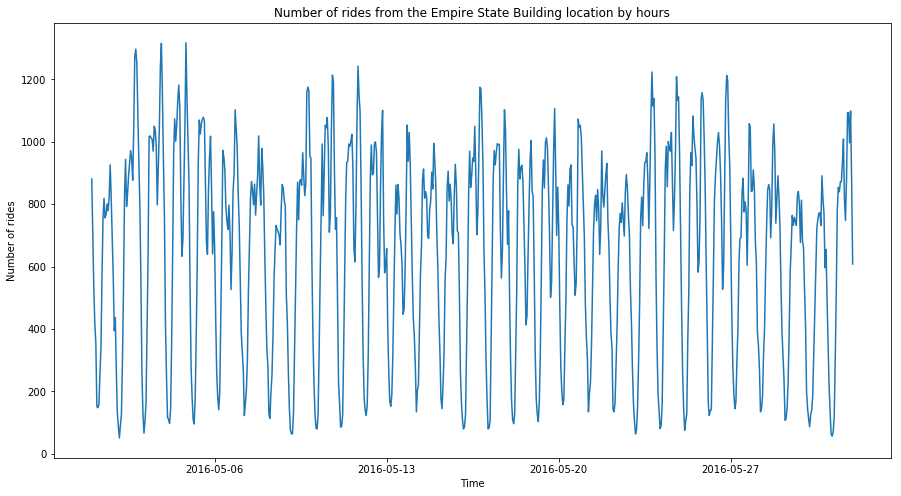

In [18]:
plt.figure(figsize(15, 8))
plt.plot(data_empire.time, data_empire.num_of_rides)
plt.ylabel('Number of rides')
plt.xlabel('Time')
plt.title('Number of rides from the Empire State Building location by hours')
plt.show()

In [19]:
print('Number of pairs (hour-region) with no rides: ', data_agregated[data_agregated.num_of_rides == 0].shape[0])

Number of pairs (hour-region) with no rides:  1718238


In [20]:
%%time
data_agregated.to_csv('data_agregated_may_2016.csv', index=None)

Wall time: 23.7 s


# 2. Analysing data

Loading aggregated trip data in May 2016.

Sum up the total number of taxi trips from each geographic area and count the number of cells from which no trips were made in May.

In [18]:
%%time
data = pd.read_csv('data_agregated_may_2016.csv')

CPU times: total: 359 ms
Wall time: 525 ms


In [19]:
data.shape

(1860000, 3)

In [20]:
rides_by_region = data.groupby(['region'])['num_of_rides'].sum()

In [21]:
print('Number of regions with no rides in May: ', 
      rides_by_region[lambda x: x == 0].shape[0])

Number of regions with no rides in May:  1283


Interactive map of New York

In [22]:
#gmaps.configure(api_key="")

In [23]:
statue_of_liberty = [(40.689262, -74.044490)]

fig = gmaps.figure(center=statue_of_liberty[0], zoom_level=13)
fig.add_layer(gmaps.marker_layer(statue_of_liberty))
fig

Figure(layout=FigureLayout(height='420px'))

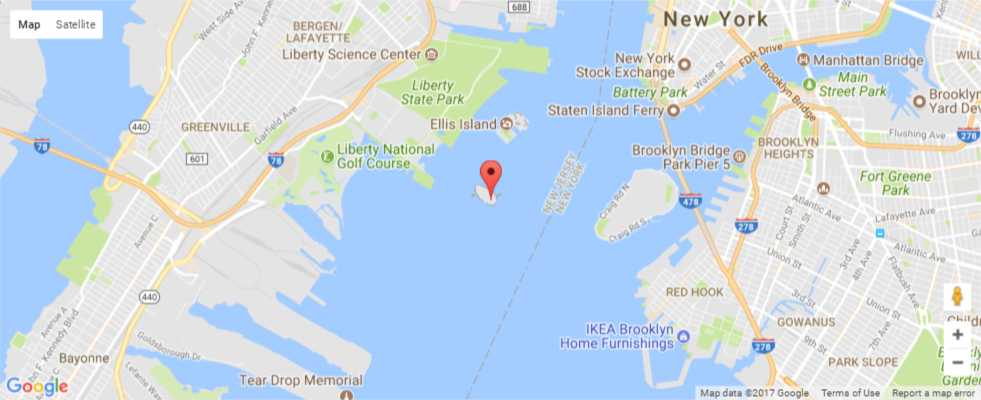

In [24]:
num_of_hours_in_may = 31*24.
rides_by_region_per_hour = rides_by_region/num_of_hours_in_may

In [25]:
json_data_1 = '{"features":[],"type": "FeatureCollection"}'
json_data_2 = '{"type": "Feature", "geometry": {"type": "Polygon","coordinates": [[]]}}'

In [26]:
my_geometry = json.loads(json_data_1)
j0 = json.loads(json_data_2)

In [27]:
regions_data = pd.read_csv('regions.csv', sep=';')

In [28]:
for region in range(1, 2501):
    west = regions_data['west'][region-1]
    east = regions_data['east'][region-1]
    south = regions_data['south'][region-1]
    north = regions_data['north'][region-1]
    
    new_region = copy.deepcopy(j0)
    new_region['geometry']['coordinates'][0] = [[west, south],
                                                          [west, north],
                                                          [east, north],
                                                          [east, south],
                                                          [west, south]]
    
    my_geometry['features'].append(new_region)

In [29]:
len(my_geometry['features'])

2500

Visualizing the trip data from each cell.

Color shows the monthly average number of taxi trips per hour from this zone.

In [30]:
min_rides = rides_by_region_per_hour.min()
max_rides = rides_by_region_per_hour.max()
rides_range = max_rides - min_rides

def calculate_color(num_of_rides):
    # make gini a number between 0 and 1
    normalized_rides = (num_of_rides - min_rides) / rides_range

    # invert gini so that high inequality gives dark color
    inverse_rides = 1.0 - normalized_rides

    # transform the gini coefficient to a matplotlib color
    mpl_color = viridis(inverse_rides)

    # transform from a matplotlib color to a valid CSS color
    gmaps_color = to_hex(mpl_color, keep_alpha=False)

    return gmaps_color

In [31]:
colors = []
for num_of_rides in rides_by_region_per_hour:
    colors.append(calculate_color(num_of_rides))

In [32]:
fig = gmaps.figure()
geojson_layer = gmaps.geojson_layer(my_geometry, 
              fill_color=colors,
              stroke_color=colors,
              fill_opacity=0.8)
fig.add_layer(geojson_layer)
fig

Figure(layout=FigureLayout(height='420px'))

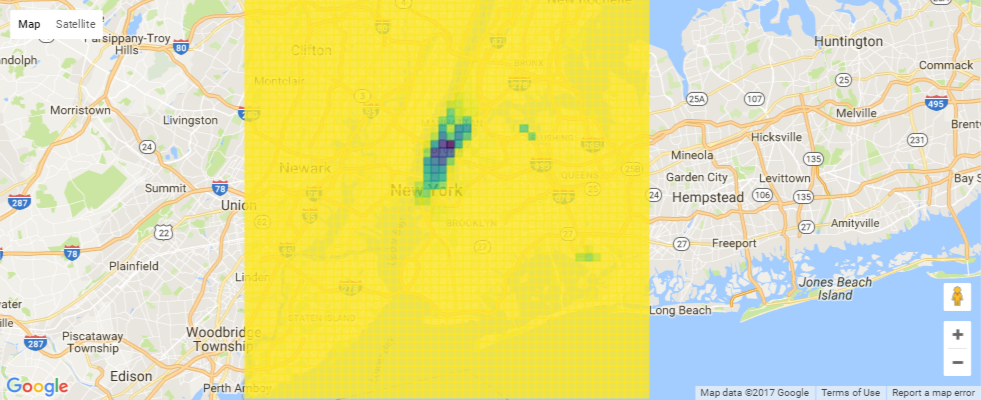

Let's filter out the cells from which less than 5 trips per hour are made on average in May.

In [33]:
rides_by_region_per_hour = rides_by_region_per_hour[lambda x: x >= 5]
print('Number of regions with 5 and more rides per hour:', rides_by_region_per_hour.shape[0])

Number of regions with 5 and more rides per hour: 102


In [34]:
my_geometry_2 = json.loads(json_data_1)

for region in rides_by_region_per_hour.keys():
    west = regions_data['west'][region-1]
    east = regions_data['east'][region-1]
    south = regions_data['south'][region-1]
    north = regions_data['north'][region-1]
    
    new_region = copy.deepcopy(j0)
    new_region['geometry']['coordinates'][0] = [[west, south],
                                                          [west, north],
                                                          [east, north],
                                                          [east, south],
                                                          [west, south]]
    
    my_geometry_2['features'].append(new_region)

In [35]:
fig3 = gmaps.figure()
geojson_layer = gmaps.geojson_layer(my_geometry_2, 
              fill_color='blue',
              stroke_color='blue',
              fill_opacity=0.8)
print('Regions with 5 and more rides per hour:')
fig3.add_layer(geojson_layer)
fig3

Regions with 5 and more rides per hour:


Figure(layout=FigureLayout(height='420px'))

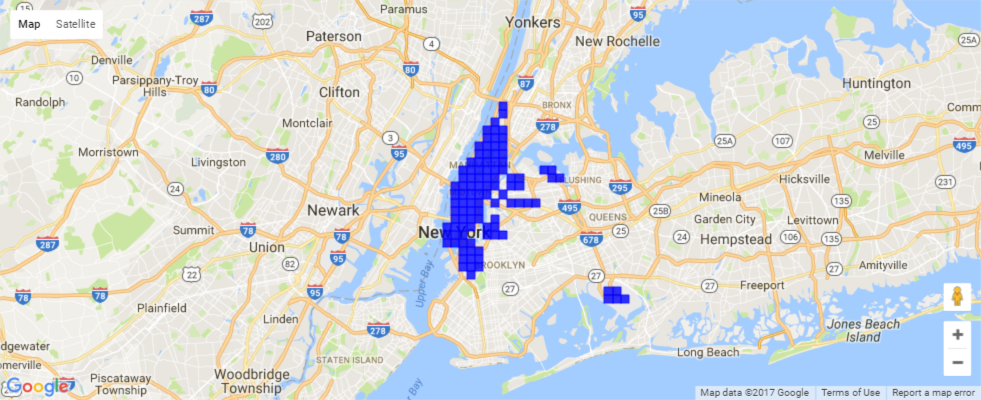

In [40]:
rides_by_region_per_hour.sort_values(ascending = False)

region
1282    858.600806
1232    742.611559
1181    698.418011
1231    657.915323
1230    639.927419
           ...    
1733      5.420699
1225      5.364247
1630      5.159946
1441      5.081989
1221      5.043011
Name: num_of_rides, Length: 102, dtype: float64

# 3. Model

To build a model, we choose trip data from the region 1231

In [2]:
target_region = 1231

In [3]:
files_agregated_data = [#'data_agregated_11_2015.csv', 'data_agregated_12_2015.csv', 'data_agregated_01_2016.csv',
                        #'data_agregated_02_2016.csv', 'data_agregated_03_2016.csv', 
                        'data_agregated_04_2016.csv', 
                        'data_agregated_05_2016.csv']

In [4]:
data = pd.DataFrame()
for f in files_agregated_data:
    raw_data = pd.read_csv(f)
    data = data.append(raw_data[raw_data.region == target_region][['time', 'num_of_rides']])

In [5]:
data.head()

,time,num_of_rides
1230,2016-04-01 00:00:00,709.0
3730,2016-04-01 01:00:00,463.0
6230,2016-04-01 02:00:00,296.0
8730,2016-04-01 03:00:00,202.0
11230,2016-04-01 04:00:00,159.0


In [6]:
data.shape

(1464, 2)

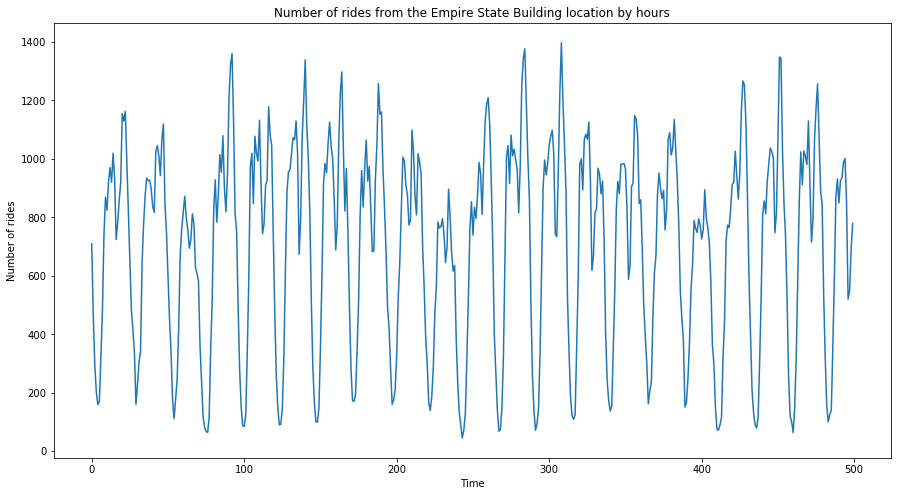

In [8]:
plt.figure(figsize(15, 8))
#plt.plot(range(data.shape[0]), data.num_of_rides)
plt.plot(range(500), data.num_of_rides.iloc[:500])

plt.ylabel('Number of rides')
plt.xlabel('Time')
plt.title('Number of rides from the Empire State Building location by hours')
plt.show()

Creating regression features

In [9]:
K = 5
T = data.shape[0]

s = np.empty((0, T))
c = np.empty((0, T))
for i in range(K):
    s_i = np.arange(1, T+1)
    c_i = np.arange(1, T+1)
    s_i = np.sin(s_i*2*np.pi*(i+1)/168)
    c_i = np.cos(c_i*2*np.pi*(i+1)/168)
    s = np.vstack((s, s_i))
    c = np.vstack((c, c_i))
s = s.T
c = c.T

In [10]:
Regr_X = np.hstack((s, c))
Regr_y = data.num_of_rides.values

In [12]:
lr = LinearRegression()
lr.fit(Regr_X, Regr_y)
Regr_y_predict = lr.predict(Regr_X)

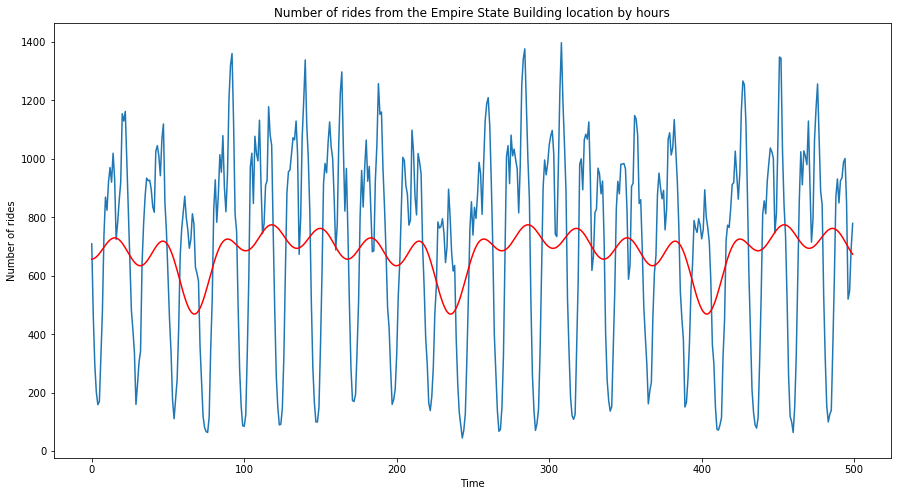

In [13]:
plt.figure(figsize(15, 8))
#plt.plot(range(data.shape[0]), data.num_of_rides)
#plt.plot(range(data.shape[0]), Regr_y_predict, c='r')
plt.plot(range(500), data.num_of_rides.iloc[:500])
plt.plot(range(500), Regr_y_predict[:500], c='r')
plt.ylabel('Number of rides')
plt.xlabel('Time')
plt.title('Number of rides from the Empire State Building location by hours')
plt.show()

In [14]:
y = data.num_of_rides - Regr_y_predict

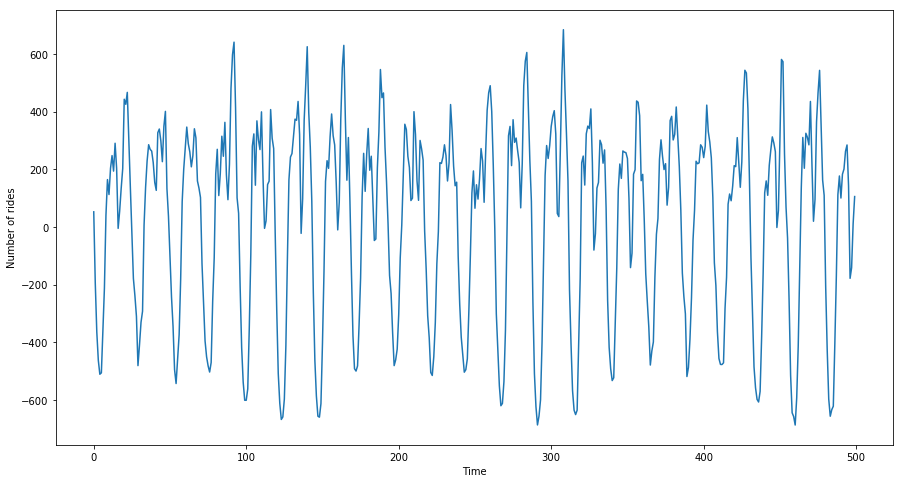

In [15]:
plt.figure(figsize(15, 8))
#plt.plot(range(data.shape[0]), y)
plt.plot(range(500), y[:500])
plt.ylabel('Number of rides')
plt.xlabel('Time')
plt.title('')
plt.show()

Stationarity check and STL decomposition of series:

In [17]:
y = pd.DataFrame(y)
y.index = pd.DatetimeIndex(data.time)

Критерий Дики-Фуллера: p=0.000000


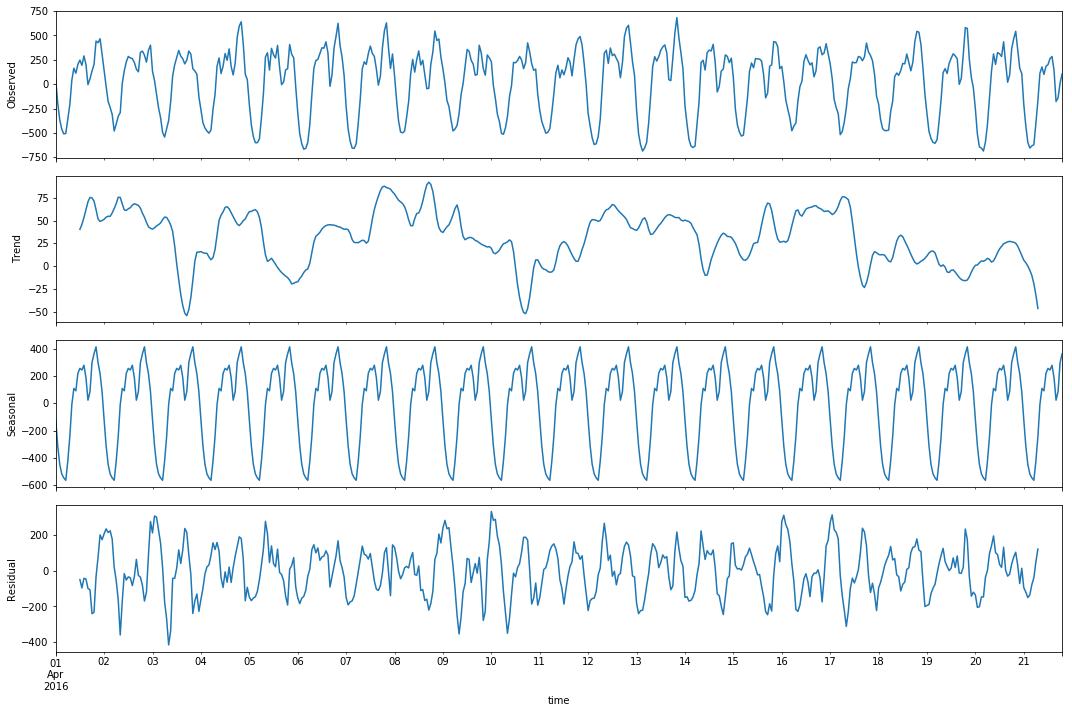

In [18]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(y.num_of_rides[:500]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y.num_of_rides[:500])[1])

Seasonal differentiation - by hours

Критерий Дики-Фуллера: p=0.000000


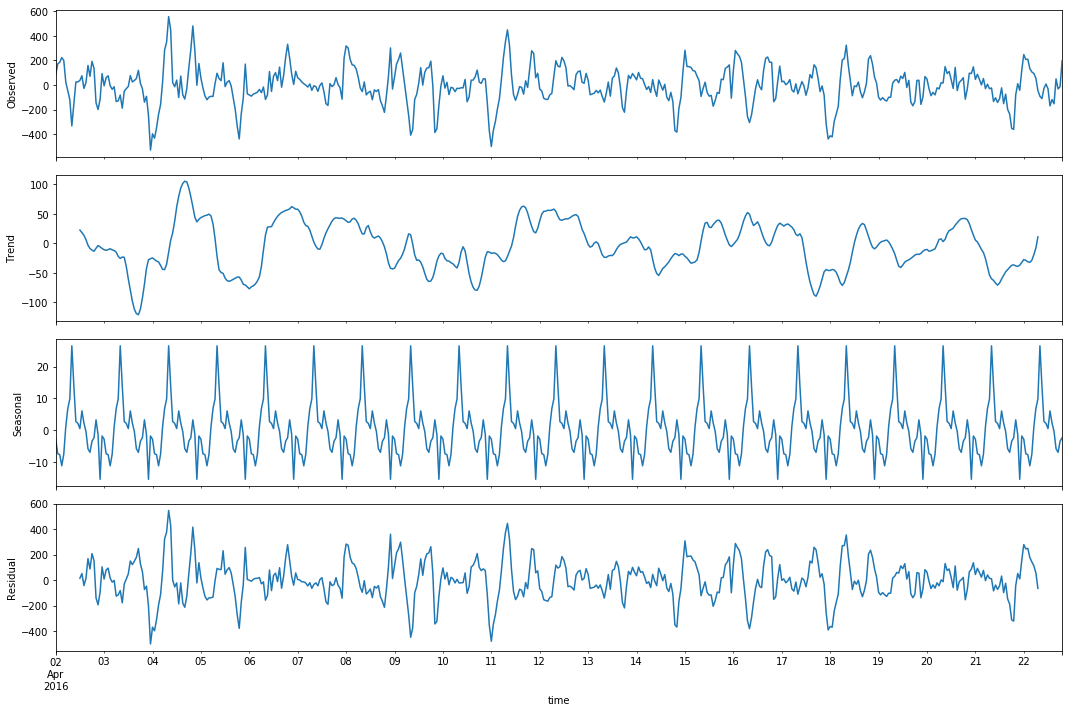

In [19]:
y['y_diff'] = y.num_of_rides - y.num_of_rides.shift(24)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(y.y_diff[24:524]).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(y.y_diff[24:])[1])

One more differentiation

Критерий Дики-Фуллера: p=0.000000


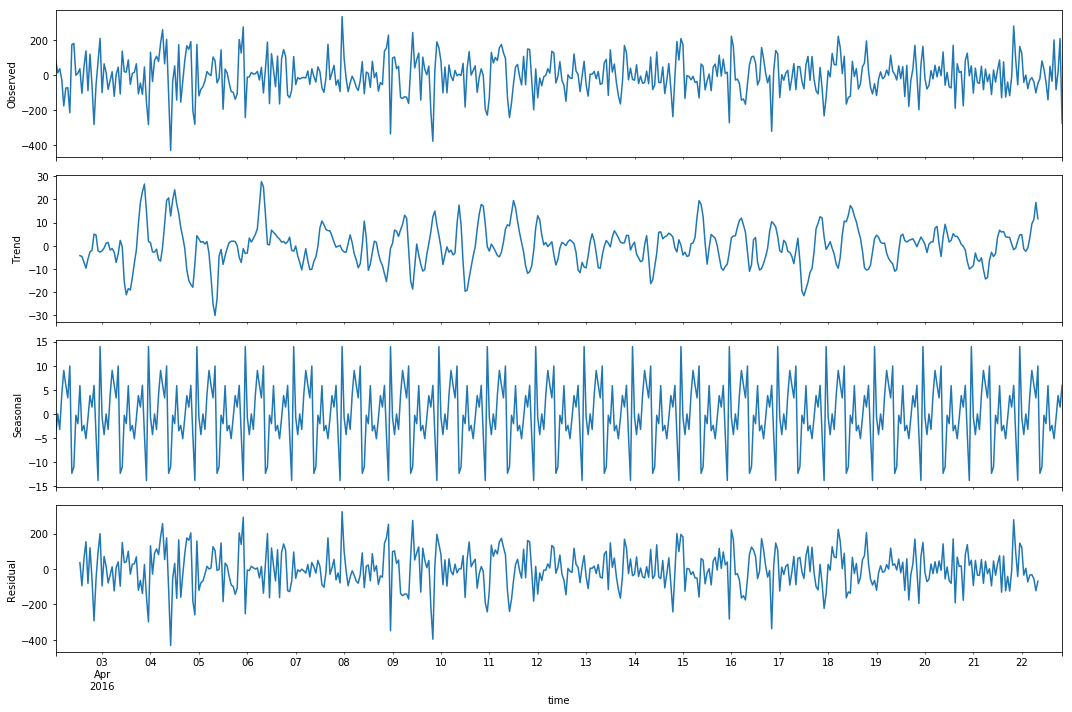

In [20]:
y['y_diff2'] = y.y_diff - y.y_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(y.y_diff2[25:525]).plot()   
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(y.y_diff2[25:525])[1])

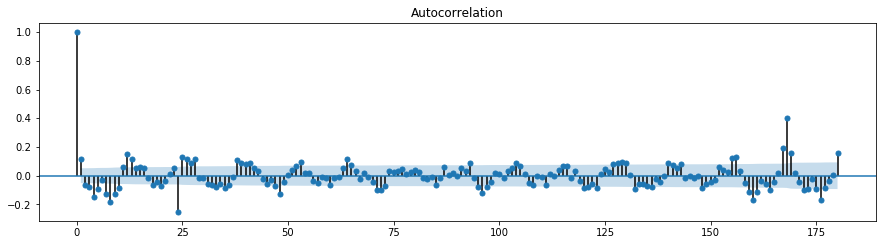

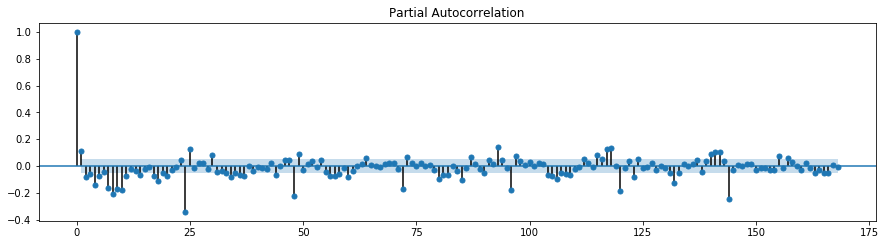

In [21]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(y.y_diff2[25:].values.squeeze(), lags=180, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(y.y_diff2[25:].values.squeeze(), lags=168, ax=ax)
pylab.show()

Q = 7, q = 9, P = 6, p = 10

We take the following parameters: Q=3, q=1, P=1, p=1

In [22]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(3, 4)

In [23]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [24]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except
    try:
        model=sm.tsa.statespace.SARIMAX(y.num_of_rides, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
        print('Ok parameters:', param)
    #display the parameters on which the model is not trained and move on to the next set
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Ok parameters: (0, 0, 0, 3)
Ok parameters: (0, 0, 1, 3)
Ok parameters: (0, 1, 0, 3)
Ok parameters: (0, 1, 1, 3)
Ok parameters: (1, 0, 0, 3)
Ok parameters: (1, 0, 1, 3)
Ok parameters: (1, 1, 0, 3)
Ok parameters: (1, 1, 1, 3)
Wall time: 17min 17s


In [25]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(10))
print()
print(best_model.summary())

     parameters           aic
3  (0, 1, 1, 3)  16876.193156
5  (1, 0, 1, 3)  16879.533405
7  (1, 1, 1, 3)  16881.429514
2  (0, 1, 0, 3)  16890.976352
6  (1, 1, 0, 3)  16892.857926
4  (1, 0, 0, 3)  16894.730829
1  (0, 0, 1, 3)  16905.574077
0  (0, 0, 0, 3)  16928.418445

                                 Statespace Model Results                                 
Dep. Variable:                       num_of_rides   No. Observations:                 1464
Model:             SARIMAX(0, 1, 1)x(1, 1, 3, 24)   Log Likelihood               -8432.097
Date:                            Mon, 02 Oct 2017   AIC                          16876.193
Time:                                    01:25:45   BIC                          16907.927
Sample:                                04-01-2016   HQIC                         16888.029
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
 

Residuals

Критерий Стьюдента: p=0.995555
Критерий Дики-Фуллера: p=0.000000


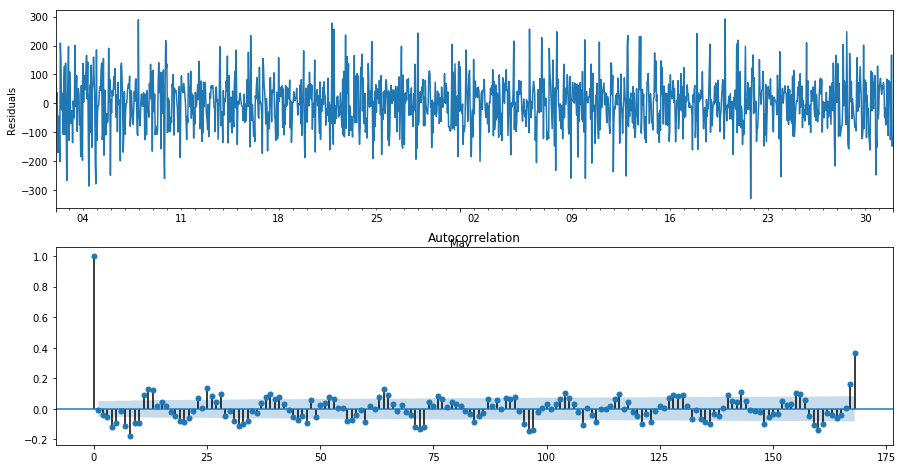

In [26]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[25:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[25:].values.squeeze(), lags=168, ax=ax)

print("Student's test: p=%f" % stats.ttest_1samp(best_model.resid[25:], 0)[1])
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[25:])[1])

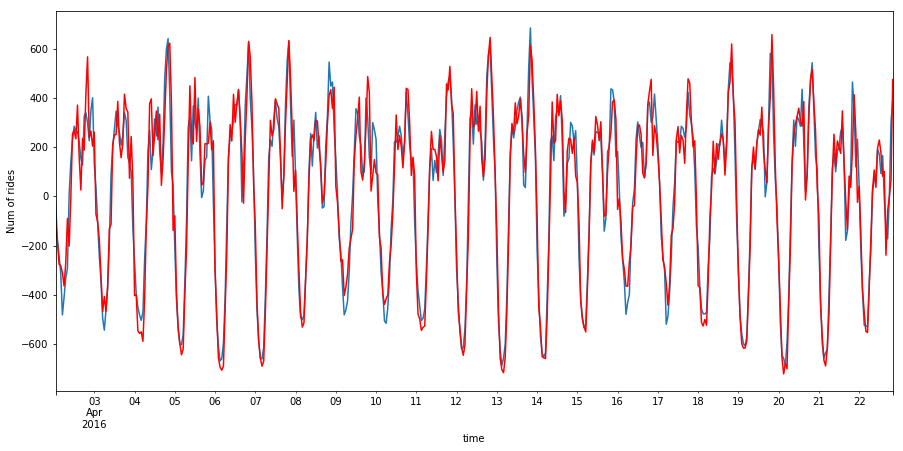

In [27]:
y['model'] = best_model.fittedvalues
#y['model_regr'] = best_model.fittedvalues + Regr_y_predict
plt.figure(figsize(15,7))
y.num_of_rides[25:525].plot()
y.model[25:525].plot(color='r')
plt.ylabel('Num of rides')
pylab.show()

# 4. Result - original series with predictions

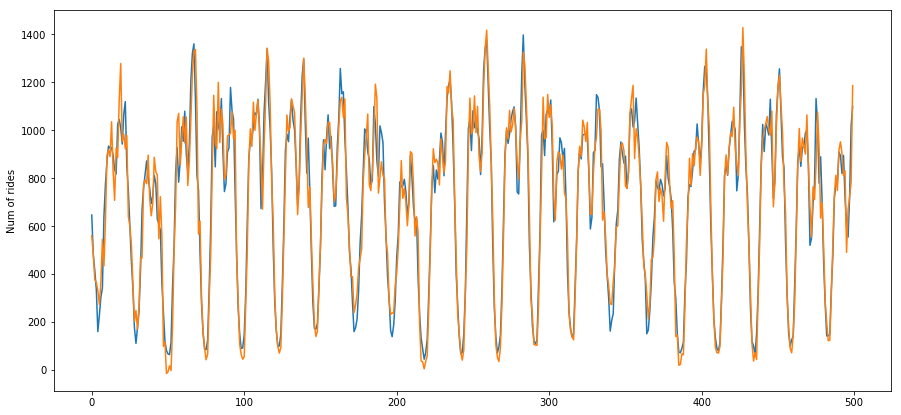

In [28]:
pred = y.model.values + Regr_y_predict
plt.figure(figsize(15,7))
#data.num_of_rides.plot()
#data.model[25:].plot(color='r')
plt.plot(data.num_of_rides[25:525].values)
plt.plot(pred[25:525])
plt.ylabel('Num of rides')
pylab.show()